# TM10007 Assignment

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.2 MB/s eta 0:00:00


## Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,LearningCurveDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from xgboost import XGBClassifier

from worcgist.load_data import load_data

## 1. Data loading

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [3]:
# Load dataset with gastrointestinal stromal tumors and similar sarcomas
data = load_data()

# Assigning the labels to binary values
data['label'] = data['label'].map({'non-GIST': 0, 'GIST': 1})

# Splitting the labels from the feature values
y = data['label'] # Use these values for calculation of performance metric
X = data.drop(columns=['label'])

# Splitting the data: 85% for training/validation, 15% for final testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)                                                       # Stratify the split to ensure an equal class distribution across the splits

### 1.1: Basic statistics

Basic statistics:
       Set  Number of samples
0  X_train                209
1  y_train                209
2   X_test                 37
3   y_test                 37

 Statistics in training + test set:
- The number of features:        493
- The number of datapoints:      103037
- The number of missing values:  0
- The number of zero values:     5689
- The percentage of zero values:  0.12 %



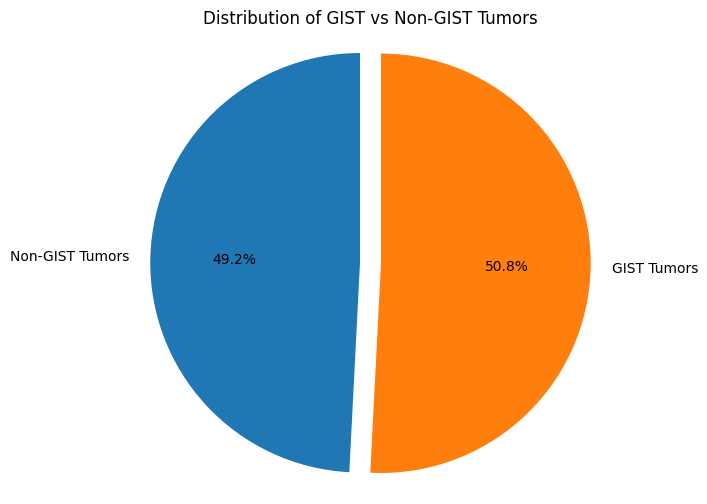

In [4]:
# Calculate basic statistics of the dataset # Beschrijving van de volgende code
data_sizes = { # Creates a dictionary to strore data
    'Set': ['X_train', 'y_train', 'X_test', 'y_test'],
    'Number of samples': [len(X_train), len(y_train), len(X_test), len(y_test)]
    }

# Convert to DataFrame for further printing of results
summary_df = pd.DataFrame(data_sizes) # Transfer dictionary to a Pandas DataFrame
n_samples = len(X_train)
n_features = len(X_train.columns)

n_missing = X_train.isna().sum().sum() # Total amount of missing values in the training set
n_zero = (X_train == 0).sum().sum() # Total amount of zeros in the training set

n_non_gist = (y == 0).sum().sum() # Total amount of 'non-GIST' tumors
n_gist = (y == 1).sum().sum() # Total amount of 'GIST' tumors

# Print basic statistics
print("Basic statistics:")
print(summary_df)
print(f'\n Statistics in training + test set:')
print(f'- The number of features:        {n_features}')
print(f'- The number of datapoints:      {n_samples * n_features}')
print(f"- The number of missing values:  {n_missing}")
print(f"- The number of zero values:     {n_zero}")
print(f"- The percentage of zero values: {n_non_gist/(n_samples*n_features)*100: .2f} %\n")

# Data for the pie chart
labels = ['Non-GIST Tumors', 'GIST Tumors'] # Labels for the pie chart
sizes = [n_non_gist, n_gist] # Data for the pie chart (amount of tumors per type)

# Create pie chart
plt.figure(figsize=(6, 6)) # Creates the figure of the pie chart of the defined size
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=(0.05, 0.05))
plt.title('Distribution of GIST vs Non-GIST Tumors')
plt.axis('equal')
plt.show()


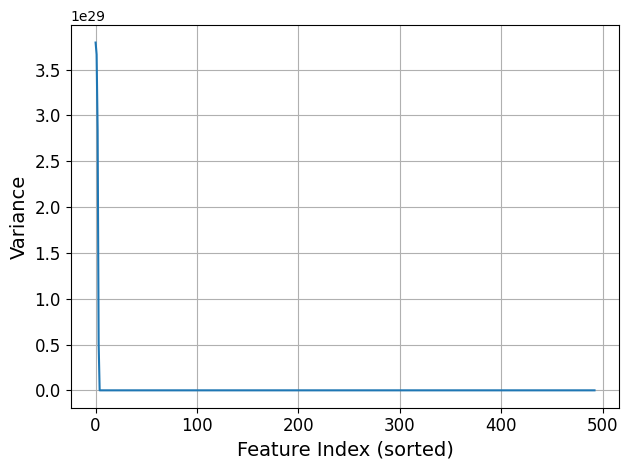

In [17]:
# Calculate variance for the features
variances = X_train.var()  # Get variance of each column
variances_sorted = variances.sort_values(ascending=False) # Sort the variances in descending order

plt.figure()  # Create a figure for the plot with specific dimensions
plt.plot(variances_sorted.values)

# Set larger font sizes
plt.ylabel('Variance', fontsize=14)
plt.xlabel('Feature Index (sorted)', fontsize=14)
# plt.title('Feature Variance (Sorted High to Low)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()


## 2. Pre-processing

The training data was preprocessed in 3 steps:


1.   Outliers replacement
2.   Scaling
3.   Low variance features removed



### 2.1: Replace outliers

In [6]:
# Parameters
threshold_nd = 3.0   # Z-score threshold for normal distribution. Used to identify outliers in normally distributed data.
threshold_nnd = 1.5  # IQR threshold for non-normal distribution. Used to identify outliers in non-normally distributed data.

# --- Step 1: Determine normality using Shapiro-Wilk ---
alpha = 0.05 # Significance level for the Shapiro-Wilk test (commonly set to 0.05).
normal_results = {} # Dictionary to store normality results for each feature.

# Loop through each column (feature) in the training data (X_train).
for col in X_train.columns:
    p_value = shapiro(X_train[col])[1]  # Get p-value from the Shapiro-Wilk test.
    normal_results[col] = p_value > alpha  # If p-value > alpha, assume the feature is normally distributed.

is_normal = pd.Series(normal_results) # Store normality results in a Pandas Series for easier access.

# --- Step 2: Calculate bounds for each feature ---
bounds = {} # Dictionary to store lower and upper bounds for each feature.
outliers_replaced_train = 0 # Counter for outliers replaced in the training set.
outliers_replaced_test = 0 # Counter for outliers replaced in the test set.

X_train_clipped = X_train.copy() # Create a copy of the training data to store clipped values.
X_test_clipped = X_test.copy() # Create a copy of the test data to store clipped values.

for column in X_train.columns:
    if is_normal[column]:
        # If the feature is normally distributed, use the Z-score method to calculate bounds:
        mean = X_train[column].mean() # Calculate the mean of the feature.
        std = X_train[column].std() # Calculate the standard deviation of the feature.
        lower = mean - threshold_nd * std # Lower bound = mean - (threshold_nd * standard deviation).
        upper = mean + threshold_nd * std # Upper bound = mean + (threshold_nd * standard deviation).
    else:
        # If the feature is not normally distributed, use the IQR method to calculate bounds:
        Q1 = X_train[column].quantile(0.25) # Calculate the first quartile (25th percentile).
        Q3 = X_train[column].quantile(0.75) # Calculate the third quartile (75th percentile).
        IQR = Q3 - Q1 # Calculate the interquartile range (IQR = Q3 - Q1).
        lower = Q1 - threshold_nnd * IQR # Lower bound = Q1 - (threshold_nnd * IQR).
        upper = Q3 + threshold_nnd * IQR # Upper bound = Q3 + (threshold_nnd * IQR).

    bounds[column] = (lower, upper) # Store the lower and upper bounds for the feature.

# --- Step 3: Apply bounds to training & test data ---
    # Calculate the number of outliers in the training and test sets:
    outliers_train = ((X_train[column] < lower) | (X_train[column] > upper)).sum()
    outliers_test = ((X_test[column] < lower) | (X_test[column] > upper)).sum()
    outliers_replaced_train += outliers_train # Add the number of outliers to the total count for the training set.
    outliers_replaced_test += outliers_test # Add the number of outliers to the total count for the test set.

    # Clip the feature values in the training and test sets using the calculated bounds:
    X_train_clipped[column] = X_train[column].clip(lower, upper) # Values below 'lower' are set to 'lower', and values above 'upper' are set to 'upper'.
    X_test_clipped[column] = X_test[column].clip(lower, upper)

# --- Step 4: display information ---
# Print summary information about the outlier handling process:
print(f"- Number of outliers clipped in training set:  {outliers_replaced_train}")
print(f"- Number of outliers clipped in test set:      {outliers_replaced_test}")
print(f"- Number of normally distributed features:     {is_normal.sum()}")
print(f"- Number of non-normally distributed features: {(~is_normal).sum()}")


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


- Number of outliers clipped in training set:  5269
- Number of outliers clipped in test set:      749
- Number of normally distributed features:     59
- Number of non-normally distributed features: 434


### 2.2. Apply scaler

Note: The Robust scaler & variance threshold are used in the Pipelines regarding the relevant models. The usage of the scaler & variance threshold in the code below is **exclusively** used to display the effect of these algorithms to the feature variance.

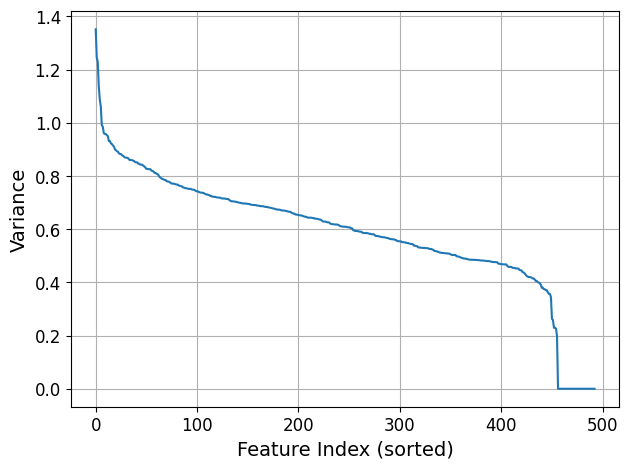

In [18]:
# Scale data using RobustScaler. Scale because some models are sensitive to feature scales (SVM, k-NN etc.)
# Robust scaler -> x(scaled) = (x - median(x)) / IQR(x)
scaler = RobustScaler()
# Calculate scaling parameters with fit_transform (median and IQR) and apply them to the training data (X_train_clipped).
X_scaled = scaler.fit_transform(X_train_clipped)
# Convert the scaled data into a Pandas DataFrame for further processing.
X_scaled_df = pd.DataFrame(X_scaled)

# Calculate the variance of each column (feature) in the scaled DataFrame.
variances = X_scaled_df.var()
# Sort the variances in descending order (highest variance first).
variances_sorted = variances.sort_values(ascending=False)

plt.figure()  # Create a figure for the plot with specific dimensions
plt.plot(variances_sorted.values)

# Set larger font sizes
plt.ylabel('Variance', fontsize=14)
plt.xlabel('Feature Index (sorted)', fontsize=14)
# plt.title('Feature Variance (Sorted High to Low)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()


### 2.3: Variance threshold

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but VarianceThreshold was fitted without feature names
  warnings.warn(


Number of features removed: 37


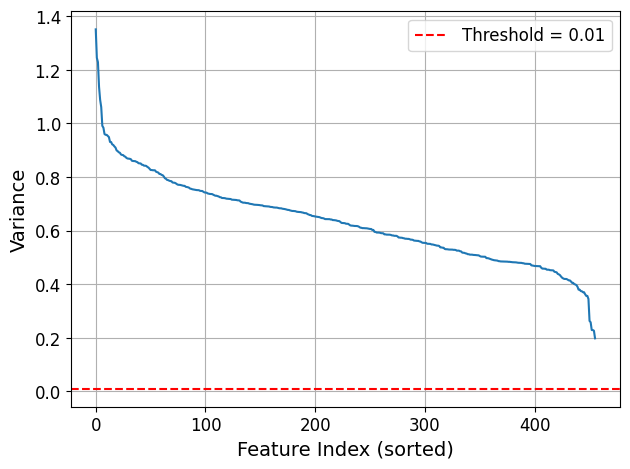

In [22]:
# Setting threshold
var_threshold = 0.01  # Set the minimum variance threshold for feature selection
selector = VarianceThreshold(threshold=var_threshold)  # Create a VarianceThreshold object from scikit-learn with the specified threshold, used to perform the feature selection

# Applying the threshold
X_train_reduced = selector.fit_transform(X_scaled)  # Apply variance thresholding to the scaled training data. Calculates variance of features and removes if below threshold.
X_test_reduced = selector.transform(X_test)  # Apply the same transformation to the test data. Remove same features in test set to prevent data leakage.

# Get selected features
selected_features = X.columns[selector.get_support()] # Get the names of the selected features

# Creating DataFrames with Selected Features
X_train_reduced_df = pd.DataFrame(X_train_reduced, columns=selected_features)  # Create a DataFrame for the reduced training data with selected features
X_test_reduced_df = pd.DataFrame(X_test_reduced, columns=selected_features)  # Create a DataFrame for the reduced test data with selected features

# Displaying Results
n_selected_features = X_train_reduced_df.shape[1]  # Get the number of selected features [1]=columns
n_removed_features = n_features - n_selected_features  # Calculate the number of removed features
print(f"Number of features removed: {n_removed_features}")  # Print the number of removed features

variances = X_train_reduced_df.var()  # Calculate the variances of the selected features
variances_sorted = variances.sort_values(ascending=False)  # Sort the variances in descending order

# Plot the variances
plt.figure()  # Create a figure for the plot with specific dimensions
plt.plot(variances_sorted.values)

# Set larger font sizes
plt.ylabel('Variance', fontsize=14)
plt.xlabel('Feature Index (sorted)', fontsize=14)
# plt.title('Feature Variance (Sorted High to Low)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=var_threshold, color='red', linestyle='--',label=f'Threshold = {var_threshold}')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Model training pipeline

### 3.1. Model pipelines

In [9]:
# Define pipelines for each classifier.

# Pipeline for Support Vector Machine (SVM)
pipeline_svm = Pipeline([
    ('scaler', RobustScaler()),                                              # Scale features
    ('remove_low_variance', VarianceThreshold(threshold=0.01)),              # Remove low-variance features
    ('feature_selection', SelectKBest(score_func=f_classif)),                # Select top features based on ANOVA F-score
    ('svm', SVC(class_weight='balanced', probability=True, random_state=42)) # SVM classifier with class balancing, and probability estimates (for evaluation purpose)
])

# Pipeline for Random Forest
pipeline_rf = Pipeline([
    ('scaler', RobustScaler()),
    ('remove_low_variance', VarianceThreshold(threshold=0.01)),              # Remove low-variance features
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)) # Random Forest with class balancing
])

# Pipeline for XGBoost
pipeline_xgb = Pipeline([
    ('scaler', RobustScaler()),                                 # Scale features
    ('remove_low_variance', VarianceThreshold(threshold=0.01)), # Remove low-variance features
    ('feature_selection', SelectKBest(score_func=f_classif)),   # Select top features based on ANOVA F-score
    ('XGB', XGBClassifier(random_state=42))                     # XGBoost classifier with default parameters
])




### 3.2: Defining hyperparameter grids

In [10]:
# Define hyperparameter ranges to be used in the grid search

# Number of features to select (SelectKBest)
param_range_K = [20, 35, 50]

# SVM regularization parameter (smaller = stronger regularization)
param_range_C = [0.01, 0.1, 1, 10, 100]

# Maximum tree depth (smaller = simpler trees, less overfitting)
param_range_depth = [3, 5, 7, None]  # None = no depth limit

# SVM parameter grid
svm_param_grid = [
    {
        'svm__kernel': ['linear'],               # Linear kernel
        'feature_selection__k': param_range_K,   # Number of features to keep
        'svm__C': param_range_C,                 # Regularization strength
    },
    {
        'svm__kernel': ['rbf'],                  # RBF (nonlinear) kernel
        'feature_selection__k': param_range_K,
        'svm__C': param_range_C,
        'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient (lower = smoother boundary)
    }
]

# Random Forest parameter grid
rf_param_grid = [{
    'rf__max_depth': param_range_depth,             # Max depth of each tree (lower = less complex)
    'rf__min_samples_leaf': [15, 30, 45],           # Minimum samples per leaf (higher = simpler trees)
    'rf__n_estimators': [50, 100],                  # Number of trees in the forest
    'rf__max_features': ['sqrt', 'log2', 0.5]       # Features considered at each split (adds randomness)
}]

# XGBoost parameter grid
xgb_param_grid = [{
    'feature_selection__k': param_range_K,          # Number of features to keep
    'XGB__max_depth': param_range_depth[:2],        # Max depth of trees (only 3 and 5 used here)
    'XGB__learning_rate': [0.01, 0.1],              # Shrinkage rate (lower = slower, more robust learning)
    'XGB__subsample': [0.5, 0.8],                   # Fraction of rows used per tree (adds randomness)
    'XGB__n_estimators': [100],                     # Number of boosting rounds (trees)
    'XGB__reg_alpha': [0, 0.1],                     # L1 regularization (sparsity)
    'XGB__reg_lambda': [0.5, 1],                    # L2 regularization (weight shrinkage)
    'XGB__gamma': [0, 0.1]                          # Minimum gain to allow a split (higher = simpler trees)
}]

### 3.3: Setup grid search

In [11]:
# Define cross-validation strategy: 6-fold stratified CV with shuffling to avoid ordering biases.
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42) # strat: balanced classes in Tr&V. 6 for 70% Tr, 15% V. Random_state -> reproducable results, every time same random distr.

# Initialize list to store grid search objects and a dictionary to map model names
grids = [] # To store all 3 grid searches
grid_dict = {}

# Grid search for Support Vector Machine (SVM)
svm_grid_search = GridSearchCV(
    estimator=pipeline_svm,         # Pipeline
    param_grid=svm_param_grid,      # Grid of hyperparameters to search
    scoring='accuracy',             # Use accuracy as the evaluation metric for best hyperparameters combination, because balanced dataset
    cv=cv,                          # Cross-validation with 6-fold stratified CV
    n_jobs=-1                       # Use all available CPU cores, use all cores of processor
)
grids.append(svm_grid_search) # Add this grid search to grids list []
grid_dict[0] = 'Support Vector Machine'

# Grid search for Random Forest
rf_grid_search = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=rf_param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)
grids.append(rf_grid_search)
grid_dict[1] = 'Random Forest'

# Grid search for XGBoost
xgb_grid_search = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=xgb_param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)
grids.append(xgb_grid_search)
grid_dict[2] = 'XGBoost'


### 3.4: Execute training

grids = [svm_grid_search, rf_grid_search, xgb_grid_search]

Loop through all GridSearch objects in grids list

So for each classifier:


1.   Take first hyperparameter combination from param_grid
2.   Divide data in 6 stratified folds (CV)
3. Train + Evaluate pipeline with those combinations
4. Repeat for all combinations
5. Choose best combination based on accuracy

--> Each pipe consists of best model and best hyperparameters





In [12]:
for pipe in grids:
    pipe.fit(X_train_clipped,y_train)

## 4. Model evaluation

In [13]:
def plot_evaluation_figures(model, model_name, X_train, y_train, X_test, y_test, cv):
    """
    Generates three evaluation plots for a trained model:
    - Cross-validated ROC curve
    - Confusion matrix on the test set
    - Learning curve (train vs. validation accuracy)
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create a subplot layout with 3 side-by-side plots

    # --- ROC with cross-validation ---
    tprs, aucs = [], []  # Store true positive rates and AUCs per fold
    mean_fpr = np.linspace(0, 1, 100)  # Define a common FPR axis for interpolation

    # Loop over each fold of the cross-validation split
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)): # Division of the training dataset into folds according to the cv defined previously
        model_clone = clone(model.best_estimator_)  # Clone an unfitted version of the best model, start with a fresh set for the next fold
        model_clone.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])  # Fit the cloned model on the current fold

        # Predict probabilities on the validation fold
        y_val_proba = model_clone.predict_proba(X_train.iloc[val_idx])[:, 1] # Calculate the probability of the positive class (1), which is found by using [:,1]
        fpr, tpr, _ = roc_curve(y_train.iloc[val_idx], y_val_proba)  # Calculate FPR & TPR from the function of a ROC

        # Interpolate TPRs over a fixed FPR range for alignment
        tpr_interp = np.interp(mean_fpr, fpr, tpr) # Interpolate the ROC over the previously defined axis (mean_fpr)
        tpr_interp[0] = 0.0   # Ensure the ROC curve starts at (0, 0), which represents no false positives or true positives
        tpr_interp[-1] = 1.0  # Ensure the ROC curve ends at (1,1)
        tprs.append(tpr_interp) # Store the interpolations for the different curves
        aucs.append(auc(fpr, tpr))  # Store the AUC scores for the different folds

        # Plot ROC curve for the current fold
        axes[0].plot(fpr, tpr, lw=1, alpha=0.4, label=f'Fold {i+1} AUC = {auc(fpr, tpr):.2f}') # Parameters: axis = fpr & tpr, linewidth, opacity of the line, legend for the different folds with 2 decimal places)

    # Compute mean and standard deviation of TPRs across folds
    mean_tpr = np.mean(tprs, axis=0) # Used for plotting the mean ROC
    std_tpr = np.std(tprs, axis=0) # Used for plotting the mean std around the curve
    mean_auc = auc(mean_fpr, mean_tpr)  # Mean AUC across folds

    # Plot the mean ROC curve with shaded variability
    axes[0].plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Mean AUC = {mean_auc:.2f}')
    axes[0].fill_between(mean_fpr, np.maximum(mean_tpr - std_tpr, 0), np.minimum(mean_tpr + std_tpr, 1),
                         color='grey', alpha=0.2, label='±1 SD') # Shaded area around the curve: maximum = lower bound of area, minimum = upper bound of area, stays between 0 and 1 to fit the plot
    axes[0].plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='red', alpha=0.5)  # Baseline line for a random classifier in a ROC

    # Format ROC plot: only format for the first subplot
    axes[0].set_title(f'Cross-validated ROC: {model_name}')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend(loc='lower right', fontsize='small')
    axes[0].grid(True)  # Add grid lines


    # --- Confusion matrix on test set ---
    y_pred = model.predict(X_test)  # Predict test set labels using the model
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=model.classes_,
        cmap='Blues', ax=axes[1]) # Compare the test data labels with the predicted test data labels in the second subplot
    axes[1].set_title(f'Confusion Matrix: {model_name}')


    # --- Learning Curve (train vs. validation performance) ---
    display = LearningCurveDisplay.from_estimator(
        estimator=model.best_estimator_,     # Use the best model from the grid search
        X=X_train,
        y=y_train,
        train_sizes=np.linspace(0.1, 1.0, 5),  # Evaluate learning curve over growing training set sizes; start at 10% of the training data, end at 100% in steps of 5
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,                           # Use all of the available UPC cores on your computer to speed up the process
        line_kw={"marker": "o"},             # Plot style: circles on lines
        std_display_style="fill_between",    # Show variability with shaded area
        score_name="Accuracy",               # Label for the Y-axis
        ax=axes[2])                          # Use third subplot
    axes[2].set_ylim(0, 1)                   # Let the y-axis (accuracy) run between 0 and 1
    axes[2].set_title(f"Learning Curve: {model_name}")



def evaluate_single_model(model, model_name, X_train, y_train, X_test, y_test):
    """
    Prints standard classification metrics and the best hyperparameters
    """
    y_pred = model.predict(X_test)  # Predict labels on test set

    # Evaluate model performance on the test set for the chosen metrics
    accuracy = model.score(X_test, y_test)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    best_params = model.best_params_

    # Print results
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"\nBest Hyperparameters: {best_params}\n")



def evaluate_models(grids, grid_dict, X_train, y_train, X_test, y_test, cv):
    """
    Iterates through a list of trained GridSearchCV models and evaluates each one

    grids = list of trained GridSearchCV models
    grid_dict = dictionary mapping model indices to model names
    """
    for i, model in enumerate(grids):
        model_name = grid_dict[i]  # Get model name from dictionary
        evaluate_single_model(model, model_name, X_train, y_train, X_test, y_test)  # Use function to print metrics
        plot_evaluation_figures(model, model_name, X_train, y_train, X_test, y_test, cv)  # Use function to print plots



=== Support Vector Machine ===
Accuracy: 0.7297
Recall: 0.7895
F1-score: 0.7500

Best Hyperparameters: {'feature_selection__k': 50, 'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


=== Random Forest ===
Accuracy: 0.5676
Recall: 0.5263
F1-score: 0.5556

Best Hyperparameters: {'rf__max_depth': 5, 'rf__max_features': 0.5, 'rf__min_samples_leaf': 15, 'rf__n_estimators': 50}


=== XGBoost ===
Accuracy: 0.6486
Recall: 0.6316
F1-score: 0.6486

Best Hyperparameters: {'XGB__gamma': 0.1, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__n_estimators': 100, 'XGB__reg_alpha': 0, 'XGB__reg_lambda': 1, 'XGB__subsample': 0.5, 'feature_selection__k': 50}



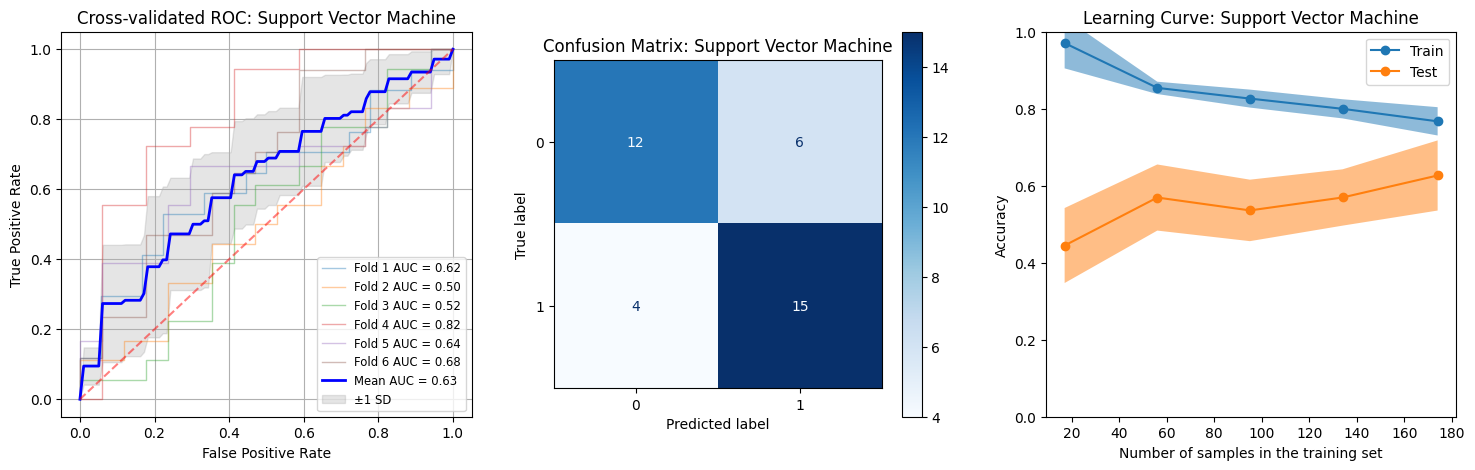

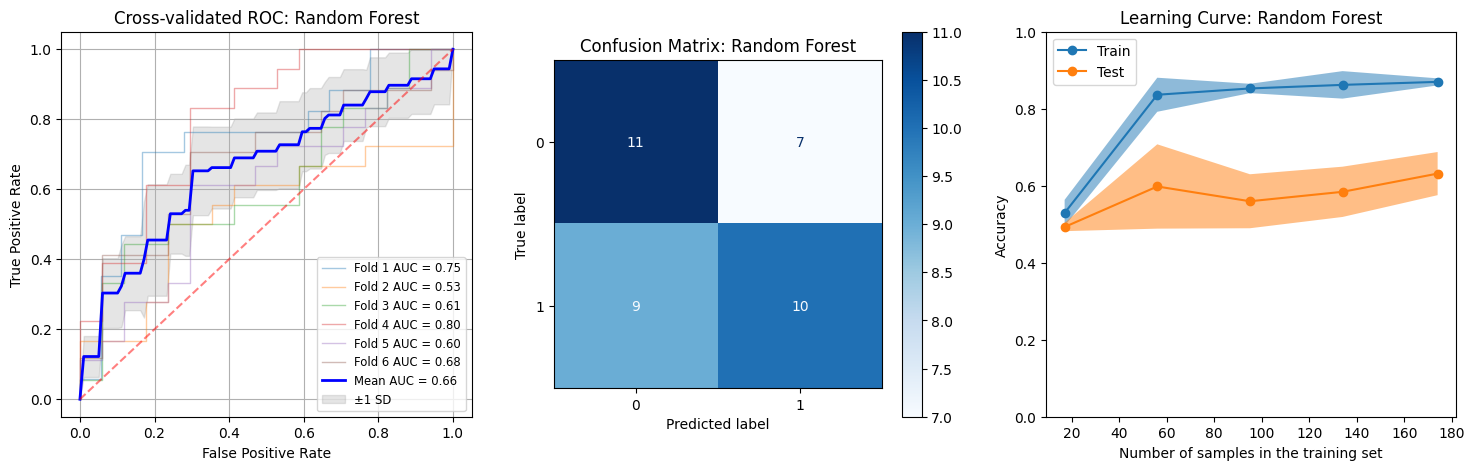

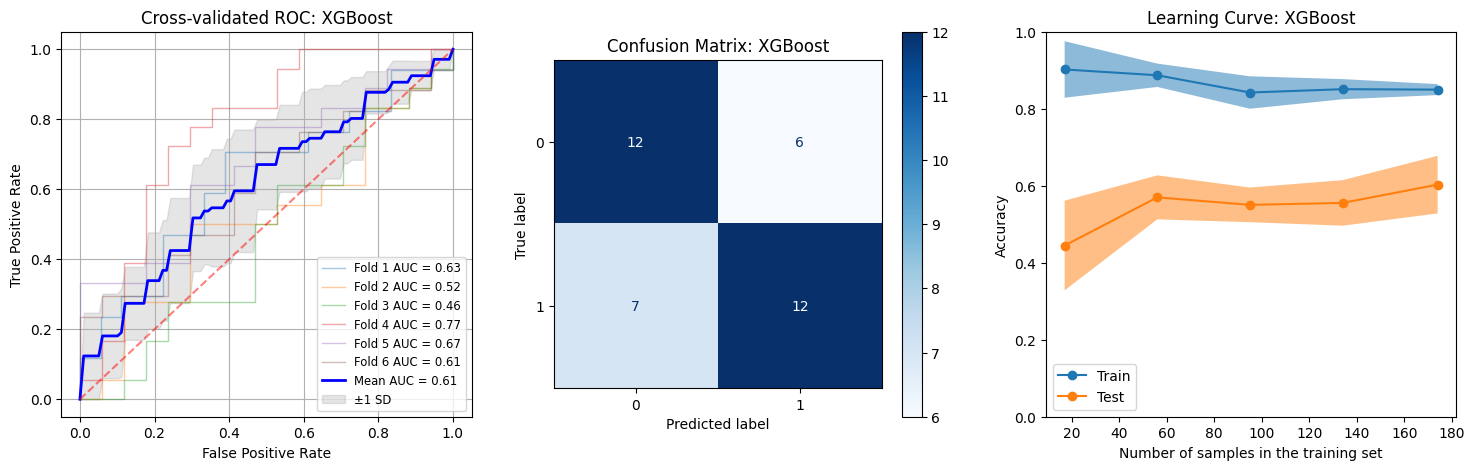

In [14]:
# Code to run the final defined function for the full evaluation of the models
evaluate_models(grids, grid_dict, X_train_clipped, y_train, X_test_clipped, y_test, cv)